# Deep learning programming I-B: Age Regression
Felix Wiewel, Institute of Signal Processing and System Theory, University of Stuttgart, 29.05.2019

## Introduction
This exercise is the second part of the regression homework in the course Deep Learning. While we covered a very basic regression task on synthetic data in the last part, we will turn to the task of age regression. The task is to infer the age of a person given a potrait picture of him or her. Intuatively this task seems to be easy at first, you are shown a potrait of a person and need to estimate his or her age. But implementing such an estimator on a computer is rather challenging. If you want to use a model based machine learning algorithm, you would need some sort of model or set of rules, which maps the raw pixel values of an image to an estimated age. This would require a lot of expert knowledge and feature design. Fortunately we can use neural networks to learn such a mapping directly from annotated examples, i.e. potraits labeled with the age of the person in the picture. In this way we just need enough examples and don't have to design the probably very complex mapping from pixels to age ourselves. We will build on the mathematical fomulation from the last exercise and take a sligthly different approach for the implementation. So it is recommended to work through the first part of the exercise before starting with this part.

## GPU support
In order to speed up calculations with tensorflow, we need to change the runtime type of this notebook to GPU. For this click on "Runtime" in the top left menu and select "Change runtime type". Then choose "GPU" in the drop down list under "Hardware accelerator". This will enable tensorflow to execute calculations on a GPU provided by Google Colab.

## Data Set
The data set we use in this exercise is called UTKFaces (https://susanqq.github.io/UTKFace/) and contains over $20000$ images of people with ages from the interval $\left[0,116\right]$. Although the individual images are labeled with the age, gender and ethnicity, we will only use the age annotation in this exercise. The images in this data set are available in two different sets. The "In-the-wild Faces" set contains images in their original size and orientation and the "Aligned&Cropped Faces" contains all images with the face aligned in the middle and the size cropped to $200\times 200$ pixels. Since the aligned and cropped set is simpler to work with and requires less memory, we will use it in this exercise. But before we can use the data set, we have to download it. We also need to install tensorflow 2.0. This is done with the following commands.

In [0]:
!pip3 install tensorflow-gpu==2.0.0-beta0
!mkdir data
!gdown https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
!mv UTKFace.tar.gz data

     |████████████████████████████████| 348.9MB 71kB/s 
     |████████████████████████████████| 3.1MB 34.8MB/s 
     |████████████████████████████████| 501kB 38.8MB/s 
Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /content/UTKFace.tar.gz
107MB [00:00, 160MB/s]  


With these commands we created a folder named "data" and downloaded the data set into it. The data set is contained in an archive, which needs to be extracted before we can work with it. Since we will need to load individual images in the coming exercise, it makes sense to first extract the data and then retreive a list with all extracted files. For this we first import all necessary packages and then define a function, which extracts the data and returns a list with all available file names and since the labels are encoded in the file names we directly extract a corresponding list of labels.

In [0]:
import tarfile
import os
import glob
import tensorflow as tf
import tensorflow.keras as k
import matplotlib.pyplot as plt
import numpy as np


def load_file_names():
    # Check if data has been extracted and if not extract it
    if (os.path.isdir("./data/UTKFace")):
        print("Data set already extracted...")
    else:
        print("Extracting data set...")
        tar = tarfile.open("./data/UTKFace.tar.gz")
        tar.extractall("./data")
        tar.close()

    # Get a list of all files in data set
    files = glob.glob("./data/UTKFace/*.jpg")
    labels = [int(f_name.split("/")[-1].split("_")[0]) for f_name in files]

      
    return files, labels

We can now use this function to plot an individual image and the age of the person in that image..

Data set already extracted...


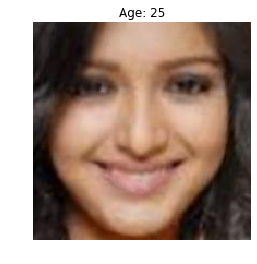

In [0]:
files, labels = load_file_names()
img = plt.imread(files[0])
plt.imshow(img)
plt.title("Age: {}".format(labels[0]))
plt.axis("off")
plt.show()

We should also check the distribution of the labels. For this we will print the unique labels contained in our data set.

In [0]:
print(np.unique(labels))

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  95  96  99 100 101 103 105 110 111 115 116]


As we can see, the data set contains only integer values as the age label. With such a distribution of labels you could also try to solve the problem of mapping an input image to an age by classifiaction. This is a valid approach but not the one we are interested in. We want to take an image of a person and regress his or her age exactly. Since the potraits in our training data set were certainly not taken in the exact moment that person's age was exactly an integer, we can conclude that the labeling is not well suited for our problem. But since these are the only labels we get for this data set, we have to use them and accept the slightly incorrect labels.

In this exercise we will use a slightly different way to define our model when compared with the previous part. This time we will derive a new model class from the Model class provided by Keras. This comes with several advantages. First, we can use predefined layer classes from Keras in order to build our model. See the [documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers) for a list of all available layers and detailed information on how to use them. Second, we don't need to manage the variables which store the weights of our model manually. Keras takes care of this and provides a list of all trainable variables of the model. Third, we can use the fit and fit_generator function of a Keras model in order to easily train our model. These functions offer a simple interface to implement a lot of different ways for training. But since sometimes one needs to implement a custom training loop, we will not use this function yet but rather implement our own training loop. Now your task is to define a suitable model architecture for the regression of a scalar value like the age of a person from an image.

In [0]:
""" Implement a small CNN with two convolutional and three dense layers. The conv. layers should have 8 and 16 filters of size 3x3, astride of 4 and a ReLU activation. Also create a flatten layer and a dropout layer 
with 0.2 droprate. The dense layers should have 128, 64 and 1 neurons and again a ReLU activation. For implementing the layers use predefined layer classes of Keras, e.g. k.layers.Conv2D or k.layers.Dense. 
Hint: Create the layer objects in the constructor and call them in the right order for implementing the forward pass. You need to pass the dropout layer the "training" argument in order to activate dropout during 
training and deactivate it during testing. """

class MyModel(k.Model):
    def __init__(self):
        # Create layers
        super(MyModel, self).__init__()
        self.conv0 = k.layers.Conv2D(8,(3,3),strides = 4,activation='relu',input_shape=(200,200,3))
        self.conv1 = k.layers.Conv2D(16,(3,3),strides = 4,activation='relu')
        self.flatten = k.layers.Flatten()
        self.dropout = k.layers.Dropout(0.2)
        self.dense0 = k.layers.Dense(128,activation='relu')
        self.dense1 = k.layers.Dense(64,activation='relu')
        self.dense2 = k.layers.Dense(1,activation='relu')

    def call(self, inputs, training=False):
        # Implement forward pass
        output = self.conv0(inputs)
        output = self.conv1(output)
        output = self.flatten(output)
        output = self.dropout(output, training)
        output = self.dense0(output)
        output = self.dense1(output)
        output = self.dense2(output)
        return output

Notice that in the previous part we defined a \__call__ function and now define a call function. This call function is required by Keras but we can still predict with the model just by calling it on an input tensor. For training the model we again need to define some hyperparameters.

In [0]:
N_epochs = 20
learning_rate = 0.001
batch_size = 64
N_training_examples = 20000
N_validation_examples = 4*batch_size

N_parallel_iterations = 4
N_prefetch = 8
N_shuffle_buffer = 20000

We will train the model for $20$ epochs with a batch size of $64$ and a learning rate of $0.001$.  We will use $20000$ examples for training $4$ batches for validation and the remaining data for testing of the model. We also define some parameters, which are used to create the Dataset objects .With these definitions we can build the data set objects used for training, validation and testing.

In [0]:
""" Since we only have the file name and labels of the images, we need to actually load an image into system memory if it is needed. For this we will define a function that parses the image, normalizes it and reshapes 
the label. This reshaping is a technical detail that avoids unintended behaivior during the calculation of the loss, i.e. it avoids unintended broadcasting. Your task is to fill in the missing code for loading, 
decoding and normalizing the image. In this example we normalize the image to pixels in the range between 0 and 1. Hint: For reading and decoding the image use the functions defined in tf.io."""

def parse_func(filename, label):
    image_string = tf.io.read_file(filename)# Read the image
    image_decoded = tf.io.decode_image(image_string,channels=3)# Decode the image
    image = image_decoded / 255 # Normalize the image
    label = tf.expand_dims(tf.cast(label, tf.float32), axis=-1)
    return image, label

""" We now build a tensorflow Dataset object that shuffles the data with a shuffle buffer of size "N_shuffle_buffer", applies the parse_func via the .map() function with "N_parallel_iterations", creates batches 
of size "batch_size" and prefetches with "N_prefetch". Please fill in the missing code. """
  
def build_dataset(files, labels, batch_size):
    # Create tf data set
    ds = tf.data.Dataset.from_tensor_slices((files,labels))# Create data set of files and labels
    ds = ds.shuffle(N_shuffle_buffer)# Enable shuffling
    ds = ds.map(parse_func,num_parallel_calls = N_parallel_iterations )# Apply parse_func
    ds = ds.batch(batch_size).prefetch(N_prefetch)# Batch and prefetch
    return ds

""" Before partitioning the data and creating the tensorflow Dataset objects for training, validation and test, we need to shuffle. Please implement a shuffling of the data and the labels. """
# Shuffle data and labels

np.random.shuffle(files)
labels = [int(f_name.split("/")[-1].split("_")[0]) for f_name in files]


train_ds = build_dataset(files[0:N_training_examples],
                                     labels[0:N_training_examples], batch_size).repeat()
validation_ds = build_dataset(files[N_training_examples:N_training_examples+N_validation_examples],
                                          labels[N_training_examples:N_training_examples+N_validation_examples],
                                          batch_size)
test_ds = build_dataset(files[N_training_examples+N_validation_examples:],
                                    labels[N_training_examples+N_validation_examples:], batch_size)



Since the we loaded the file names of individual images and their corresponding labels, we need to load the actual image given its filename. For this we use the map function of the Dataset class. This function applies a function, in our case the parse_func function, to every sample in a batch. The parse_func function then reads the actual image given its name, decodes and normalizes it. It also makes sure that we use the correct dimensions and data types. With the build_dataset function we can then build a Dataset obejct, which first shuffles then applies the parse_func function and finnaly batches the data. In order to iterate many times over the data set we repeat this process indefenetly.

In order to train the model we again use a function which does one training step. This function is similar to the previous part of this exercise with the addition of the @tf.function decorator, which tells tensorflow to build this function as a graph in order to speed upo repeated calls to it. We also use the mean absolute error (MAE) as a loss for training the model. This loss can be derived in the same way as in the previous part if we assume laplacian distributed noise in out signal model.

In [0]:
""" For this application we will use the Mean Absolute Error (MAE) as a loss function for training. Please implement the loss and the training step."""
temp = None
# Define loss function
def loss(y, y_pred):
    return tf.reduce_mean(tf.abs(y-y_pred))# MAE between "y" and "y_pred"

# Define training step as a complete graph
@tf.function
def train_step(model, optimizer, x, y):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        y_pred = model(x,training=True)# Predict with model on "x"
        loss_val = loss(y,y_pred)# Compute the loss with "y" and "y_pred"
    temp = model.trainable_variables
    grads = tape.gradient(loss_val, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_val

Now we just need to instantiate an instance of our model and an optimizer in order to start training. We also build the model in order to be able to print it's summary.

In [0]:
mdl = MyModel()
opt = tf.optimizers.RMSprop(learning_rate)
mdl.build((batch_size, 200, 200, 3))
mdl.summary()

Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            multiple                  224       
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  1168      
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  295040    
_________________________________________________________________
dense_4 (Dense)              multiple                  8256      
_________________________________________________________________
dense_5 (Dense)              multiple                  6

We use a similar loop as in the previous part of this exercise for training.

In [0]:
# Run training
epoch = 0
train_loss = 0.0
train_iters = 0
for train_images, train_labels in train_ds:
    train_loss += train_step(mdl,opt,train_images,train_labels)# Perform a train step
    train_iters += 1
    if (int(N_training_examples / batch_size) == train_iters ):# An epoch is completed
        epoch += 1
        val_loss = 0.0
        val_iters = 0
        for val_images, val_labels in validation_ds:
            y_pred = mdl(val_images)# Predict on validation images
            loss_val = loss(val_labels,y_pred)# Compute loss for validation
            val_loss += loss_val
            val_iters += 1
            if val_iters == int(N_validation_examples/batch_size):
                print("Epoch: {} Training loss: {:.5} Validation loss {:.5}"
                      .format(epoch, train_loss/train_iters, val_loss/val_iters))
                break
        train_loss = 0.0
        train_iters = 0
    if epoch == N_epochs:
        break

Epoch: 1 Training loss: 15.678 Validation loss 15.041
Epoch: 2 Training loss: 13.419 Validation loss 14.979
Epoch: 3 Training loss: 12.001 Validation loss 11.97
Epoch: 4 Training loss: 10.932 Validation loss 11.065
Epoch: 5 Training loss: 10.263 Validation loss 11.101
Epoch: 6 Training loss: 9.764 Validation loss 10.491
Epoch: 7 Training loss: 9.4955 Validation loss 10.169
Epoch: 8 Training loss: 9.2063 Validation loss 9.4224
Epoch: 9 Training loss: 9.0674 Validation loss 9.3944
Epoch: 10 Training loss: 8.9026 Validation loss 9.4463
Epoch: 11 Training loss: 8.708 Validation loss 9.1426
Epoch: 12 Training loss: 8.5649 Validation loss 9.1157
Epoch: 13 Training loss: 8.4473 Validation loss 9.3014
Epoch: 14 Training loss: 8.2764 Validation loss 8.6043
Epoch: 15 Training loss: 8.1913 Validation loss 8.4163
Epoch: 16 Training loss: 8.0677 Validation loss 8.648
Epoch: 17 Training loss: 7.9986 Validation loss 9.636
Epoch: 18 Training loss: 7.8735 Validation loss 9.4623
Epoch: 19 Training loss:

Testing the model on the test data set is also similar to the previous part of this exercise.

In [0]:
# Test model
test_loss = 0.0
test_iters = 0
for test_images, test_labels in test_ds:
    y_pred = mdl(test_images)# Predict on test images
    test_loss += loss(test_labels,y_pred)# Compute test loss
    test_iters += 1
   # print((test_labels,y_pred))
    if test_iters == int((len(files)-N_training_examples-N_validation_examples)/batch_size):
        print("Test loss: {:.5}".format(test_loss/test_iters))
        break

Test loss: 8.3023


We again can compare the training, validation and test losses in order to verify if our model is overfitting or not. We can now also upload our own images and predict on them. For this we need to upload an image which contains a quadratic potrait with the face aligned in the center.

In [0]:
from google.colab import files
uploaded = files.upload()
fn = list(uploaded.keys())[0]


  

Saving AE.jpg to AE (5).jpg


Now we do a prediction  and plot the result.

(1, 200, 200, 3)


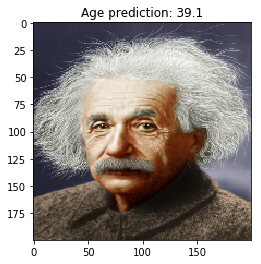

In [0]:
""" For predicting on the uploaded image, open and decode it using tf.io. After that we also need to normalize and resize it using tf.image.resize. Hint: For predicting with our model we need to add a batch dimension
of 1, since we effectively feed our model with a batch containing only one image."""

# Load and predict on an image
image_string = tf.io.read_file(fn)# Load image with path "fn"
image_decoded = (tf.io.decode_image(image_string,channels = 3))# Decode the image and add a batch dimension
image = (tf.cast((tf.image.resize((image_decoded / 255),[200,200])),tf.float32)) #Normalize, resize to 200x200 pixels and cast image to tf.float32
image = tf.expand_dims(image,0)
print(image.shape)
age = mdl(image)
lossp = loss(35,age)
# Plot image and prediction
plt.imshow(np.squeeze(image.numpy()))
plt.title("Age prediction: {:.3}".format(np.squeeze(age.numpy())))
plt.show()

## Conclusion
In this part of the exercise we have applied the concept of regression to the problem of estimating the age of a person from his or her potrait. In this process we have seen how to load images from their filenames with the map function of the Dataset class. With this, images are loaded just in time as they are needed, which is beneficial if you are working with a large number of high resolution images that do not fit into your system memory all at once. We also used Keras in order to build our model from predefined layers. If the layers you need for building your model are available through Keras, it is highly recommended to use those in order to speed up develpment time and reduce possible error sources. We also observed that the labeling of the individual images is not optimal for our task, since it is rounded to integer ages and in the setting of regression we would rather like to have continuous age labels.